In [1]:
import numpy as np
import time
import tensorflow as tf
from matplotlib import pyplot as plt

**Load the CIFAR-100 Dataset**

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [3]:
print("\n x_train.shape: ", x_train.shape)
print("\n y_train.shape: ", y_train.shape)

print("\n x_test.shape: ", x_test.shape)
print("\n y_test.shape: ", y_test.shape)


 x_train.shape:  (50000, 32, 32, 3)

 y_train.shape:  (50000, 1)

 x_test.shape:  (10000, 32, 32, 3)

 y_test.shape:  (10000, 1)


**Visualize the dataset**

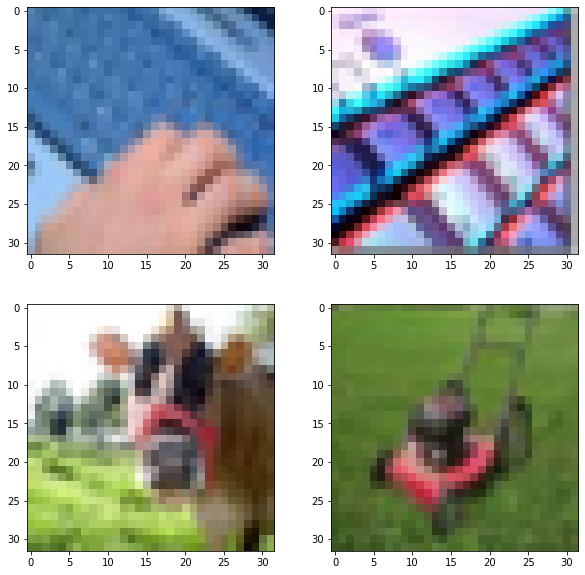

In [4]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 10))

axes[0, 0].imshow(x_train[10])
axes[0, 1].imshow(x_train[200])
axes[1, 0].imshow(x_train[0])
axes[1, 1].imshow(x_train[500])

In [5]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 100)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 100)

**Divide the data into train, test and validation**

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
np.random.seed(0)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8)

print("\n x_train.shape: ", x_train.shape)
print("\n y_train.shape: ", y_train.shape)

print("\n x_val.shape: ", x_val.shape)
print("\n y_val.shape: ", y_val.shape)

print("\n x_test.shape: ", x_test.shape)
print("\n y_test.shape: ", y_test.shape)


 x_train.shape:  (40000, 32, 32, 3)

 y_train.shape:  (40000, 100)

 x_val.shape:  (10000, 32, 32, 3)

 y_val.shape:  (10000, 100)

 x_test.shape:  (10000, 32, 32, 3)

 y_test.shape:  (10000, 100)


**Creating Residual Block**

In [8]:
from tensorflow.keras import activations

In [9]:
def create_residual_block(val_in, filter_in, filter_out):
    '''
    @params val_in : Input shape
    @params filter_in : Input filter
    @params filter_out : Output filter
    @output : Tensor created after residual block
    '''
    
    # Repeat BN=>ReLU=>Conv2D pattern three times
    
    x = tf.keras.layers.BatchNormalization()(val_in)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_in, kernel_size = 1, padding = 'same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 3, padding = 'same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 1, padding = 'same')(x)
    
    val_in = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 1, padding = 'same')(val_in)
    
    x = tf.keras.layers.Add()([val_in, x])
    
    return x

**Creating Attention Block**

The attention Module consists of mask branch and trunk branch. The trunk branch performs feature selection (using the residual blocks) and the mask branch learns the mask to be applied from downsampling and upsampling. The output of the attention block is (1+M(x)).T(x), where M(x) is the mask and T(x) is the output of the trunk branch (pre-processing).

In [10]:
def create_attention_block(val_in, filter_in, filter_out, p = 1, t = 2, r = 1):
    '''
    @params val_in : Input shape
    @params filter_in : Input filter
    @params filter_out : Output filter
    @params p : Number of pre-processing residual units before splitting into trunk and mask branch (is also a hyperparameter)
    @params t : Number of residual units in trunk branch (is also a hyperparameter)
    @params r : Number of residual units between adjacent pooling layer in the mask branch (is also a hyperparameter)
    @output: Tensor created after attention block
    '''
    
    # Creating residual blocks for pre-processing residual units
    for units in range(p):
        val_in = create_residual_block(val_in, filter_in, filter_out)
     
    val_out_trunk = val_in
    
    # Feature Processing for the trunk branch. Input to the trunk branch is the output of the pre-processing residual blocks
    for units in range(t):
        val_out_trunk = create_residual_block(val_out_trunk, filter_in, filter_out)
        
    # 1. Downsample using MaxPool2D
    # 2. 'r' represents the number of residual units between two max pool layers in the mask branch. Implemented using for loop
    # 3. Add skip connection
    # 4. Upsample using UpSampling2D
    
    
    # Down Sampling One
    soft_mask_output = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(val_in)
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    
    # Adding Skip Connection
    skip_connection = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    # Down Sampling Two
    soft_mask_output = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(soft_mask_output)
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    # Up Sampling One
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
        soft_mask_output = tf.keras.layers.UpSampling2D(size=2)(soft_mask_output)
        soft_mask_output = tf.keras.layers.Add()([soft_mask_output, skip_connection])
        
    # Up Sampling Two
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    soft_mask_output = tf.keras.layers.UpSampling2D(size=2)(soft_mask_output)
    
    soft_mask_output = tf.keras.layers.Conv2D(filter_in, kernel_size=1)(soft_mask_output)
    soft_mask_output = tf.keras.layers.Conv2D(filter_in, kernel_size=1)(soft_mask_output)
    soft_mask_output = tf.keras.layers.Activation(activation='sigmoid')(soft_mask_output)
    
    # Output is (1 + M(x))*T(x)
    output = tf.keras.layers.Lambda(lambda x: x + 1)(soft_mask_output)
    output = tf.keras.layers.Multiply()([output, val_out_trunk]) 
    
    for i in range(p):
        output = create_residual_block(output, filter_in, filter_out)

    return output

**Creating the Model**

In [11]:
def create_model(size, classes):
    '''
    @params size : Input tensor siz
    @params classes : Number of output classes
    @output : Returns the model created by attention modules
    '''
    val_in = tf.keras.layers.Input(shape=size)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same')(val_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=1, padding='same')(x)

    x = create_residual_block(val_in=x, filter_in=32, filter_out=128)
    x = create_attention_block(val_in=x, filter_in=32, filter_out=32)

    x = create_residual_block(val_in=x, filter_in=64, filter_out=128)
    x = create_attention_block(val_in=x, filter_in=64, filter_out=64)

    x = create_residual_block(val_in=x, filter_in=128, filter_out=256)
    x = create_attention_block(val_in=x, filter_in=128, filter_out=128)

    x = create_residual_block(val_in=x, filter_in=128, filter_out=256)
    x = create_residual_block(val_in=x, filter_in=256, filter_out=256)
    x = create_residual_block(val_in=x, filter_in=256, filter_out=256)

    x = tf.keras.layers.AveragePooling2D(pool_size=4)(x)
    x = tf.keras.layers.Flatten()(x)

    output = tf.keras.layers.Dense(classes, activation='softmax')(x)


    return tf.keras.models.Model(val_in, output)

**Initialize the Model**

In [12]:
model_cifar_100 = create_model(x_train.shape[1:], 100)

model_cifar_100.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

2021-12-12 21:37:47.509605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 21:37:47.658637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 21:37:47.659391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 21:37:47.661487: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Viusalize the Model**

To visualize the model, we use the Netron Package

1. Install netron using the pip command below

2. Download Netron package from here : https://github.com/lutzroeder/netron/releases/tag/v5.4.3

3. Save the model using the command below

4. Open and visualize the saved model with Netron

In [29]:
pip install netron

     |████████████████████████████████| 1.3 MB 13.9 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [30]:
model_cifar_100.save('model_cifar_100.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


**Train the Model**

In [13]:
model_cifar_100.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

tic = time.time()
history_model_cifar_100 = model_cifar_100.fit(x_train, y_train, batch_size = 32, epochs = 50, validation_data = (x_test, y_test))
toc = time.time()

Epoch 1/50


2021-12-12 21:38:41.268557: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


1250/1250 [==============================] - 154s 106ms/step - loss: 4.5178 - accuracy: 0.1362 - val_loss: 3.7476 - val_accuracy: 0.1774
Epoch 2/50
1250/1250 [==============================] - 140s 112ms/step - loss: 3.0783 - accuracy: 0.2613 - val_loss: 3.0612 - val_accuracy: 0.2637
Epoch 3/50
1250/1250 [==============================] - 130s 104ms/step - loss: 2.7644 - accuracy: 0.3199 - val_loss: 3.1023 - val_accuracy: 0.2635
Epoch 4/50
1250/1250 [==============================] - 139s 111ms/step - loss: 2.5428 - accuracy: 0.3658 - val_loss: 2.8697 - val_accuracy: 0.3092
Epoch 5/50
1250/1250 [==============================] - 130s 104ms/step - loss: 2.3390 - accuracy: 0.4091 - val_loss: 2.7973 - val_accuracy: 0.3229
Epoch 6/50
1250/1250 [==============================] - 139s 111ms/step - loss: 2.1164 - accuracy: 0.4526 - val_loss: 2.6146 - val_accuracy: 0.3548
Epoch 7/50
1250/1250 [==============================] - 128s 102ms/step - loss: 1.8812 - accuracy: 0.5043 - val_loss: 2.720

In [14]:
print("\n Time to train CIFAR-100 on V100 with 50 epochs: ", (toc - tic)/60, "mins")


 Time to train CIFAR-100 on V100 with 50 epochs:  111.54158028364182 mins


Text(0.5, 1.0, 'Loss vs Epochs')

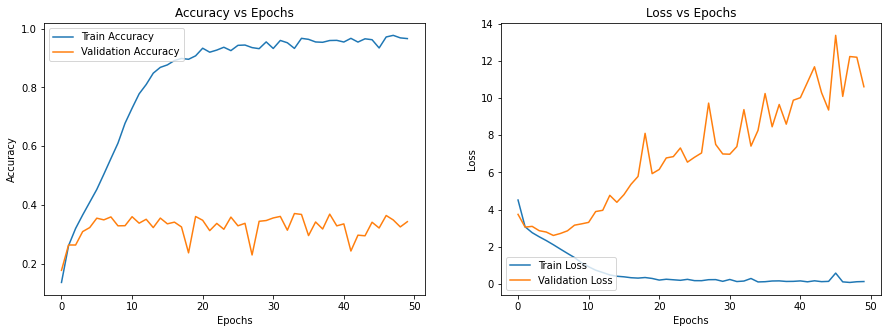

In [15]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))

axes[0].plot(history_model_cifar_100.history['accuracy'], label = 'Train Accuracy')
axes[0].plot(history_model_cifar_100.history['val_accuracy'], label = 'Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc = "upper left")
axes[0].set_title("Accuracy vs Epochs")

axes[1].plot(history_model_cifar_100.history['loss'], label = 'Train Loss')
axes[1].plot(history_model_cifar_100.history['val_loss'], label = 'Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(loc = "lower left")
axes[1].set_title("Loss vs Epochs")